# MedNIST Federated Learning
 **Goal: Train and Evaluate Performance (Accuracy, AUC, F1-Score) on two MedNIST Datasets, Retina (ordinal regression) & OCT (multi-class) in three paradigms:** 

1. Centrally Trained
2. POC Federated Environment (1 node, running 2 clients)
3. Federated Deployment (2 nodes, each running 1 client) 
4. Multi-institutional Federated Deployment

In [9]:
# Install Packages
import sys
import os
from glob import glob
from six.moves import urllib
import tarfile
#
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import PIL
from PIL import Image
#
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage import io
from skimage import color
#
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import statistics
from itertools import cycle
#
import time
from tqdm import trange
from tqdm import tqdm
import cv2
import warnings
warnings.filterwarnings('ignore')
#
from collections import Sequence
from medmnist.info import INFO, HOMEPAGE, DEFAULT_ROOT
from collections import namedtuple

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/10243,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/10243,1), 'GB')

Using device: cpu


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/10243,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/10243,1), 'GB')

Using device: cpu


In [3]:
pwd

'/Users/christianraimondo/cdr9650/MedMNIST'

In [4]:
# Download dataset (we want the .png and csv files for splitting in federated config)
#pip install --upgrade git+https://github.com/MedMNIST/MedMNIST.git
# python -m medmnist save --flag=octmnist --folder= ./octnmist --postfix=png
# python -m medmnist save --flag=retinamnist --folder=./MedMNIST/ --postfix=png

In [4]:
! ls

MedNIST-FL-Jupyter-OCT-HPC-EvalModels-Copy1.ipynb
MedNIST-FL-Jupyter-OCT-HPC-EvalModels.ipynb
MedNIST-FL-Jupyter-OCT-SCRATCH.ipynb
MedNIST-FL-Jupyter-OCT.ipynb
MedNIST-FL-Jupyter-Retina.ipynb
MedNIST-Jupyter.ipynb
input
octmnist.npz
octmnist_input
output
retinamnist.npz
retinamnist_input


In [6]:
! ls ./octmnist/octmnist_input

octmnist_images			trainlabels_site2_SUBSET25.csv
octmnist_labels.csv		vallabels_site1_SUBSET15.csv
octmnist_labels_test.csv	vallabels_site1_SUBSET20.csv
octmnist_labels_train.csv	vallabels_site1_SUBSET25.csv
octmnist_labels_val.csv		vallabels_site1_SUBSET.csv
trainlabels_site1_SUBSET15.csv	vallabels_site2_SUBSET15.csv
trainlabels_site1_SUBSET20.csv	vallabels_site2_SUBSET20.csv
trainlabels_site1_SUBSET25.csv	vallabels_site2_SUBSET25.csv
trainlabels_site2_SUBSET15.csv	vallabels_site2_SUBSET.csv
trainlabels_site2_SUBSET20.csv


### OCT Dataset

In [7]:
!  python -m medmnist info --flag=octmnist

{'MD5': 'c68d92d5b585d8d81f7112f81e2d0842',
 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid '
                'optical coherence tomography (OCT) images for retinal '
                'diseases. The dataset is comprised of 4 diagnosis categories, '
                'leading to a multi-class classification task. We split the '
                'source training set with a ratio of 9:1 into training and '
                'validation set, and use its source validation set as the test '
                'set. The source images are gray-scale, and their sizes are '
                '(384−1,536)×(277−512). We center-crop the images and resize '
                'them into 1×28×28.',
 'label': {'0': 'choroidal neovascularization',
           '1': 'diabetic macular edema',
           '2': 'drusen',
           '3': 'normal'},
 'license': 'CC BY 4.0',
 'n_channels': 1,
 'n_samples': {'test': 1000, 'train': 97477, 'val': 10832},
 'python_class': 'OCTMNIST',
 'task': 'multi-cla

### Data Pre-Processing

In [10]:
# Labels CSV 
train_labels = pd.read_csv('./octmnist_input/octmnist_labels_train.csv')
val_labels = pd.read_csv('./octmnist_input/octmnist_labels_val.csv')
test_labels = pd.read_csv('./octmnist_input/octmnist_labels_test.csv')

print('Train Dataset Shape:', train_labels.shape)
print('Validation Dataset Shape:', val_labels.shape)
print('Test Dataset Shape:', test_labels.shape)

train_labels.head()

Train Dataset Shape: (97477, 3)
Validation Dataset Shape: (10832, 3)
Test Dataset Shape: (1000, 3)


,split,image,label
0,TRAIN,train0_0,0
1,TRAIN,train1_3,3
2,TRAIN,train2_3,3
3,TRAIN,train3_3,3
4,TRAIN,train4_0,0


In [11]:
print('Train label frequencies\n',train_labels['label'].value_counts())

Train label frequencies
 3    46026
0    33484
1    10213
2     7754
Name: label, dtype: int64


In [12]:
print('Val label frequencies\n',val_labels['label'].value_counts())

Val label frequencies
 3    5114
0    3721
1    1135
2     862
Name: label, dtype: int64


In [13]:
print('Test label frequencies\n',test_labels['label'].value_counts())

Test label frequencies
 3    250
2    250
0    250
1    250
Name: label, dtype: int64


### ResNet18 Dataloader

In [14]:
data_transform = transforms.Compose([
                                    #transforms.RandomHorizontalFlip(),
                                    #transforms.ColorJitter(brightness =0.5, hue = 0.5, 
                                                           #saturation = 0.5, contrast = 0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])


     
class Dataset_resnet18(Dataset):

    def __init__(self, csv_file, image_path, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.image_path = image_path
        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_path,
                                self.data_frame.iloc[idx, 1] + '.png')
        
        image = Image.open(img_name).convert('RGB') 
        
        image = data_transform(image)
                
        image_class = self.data_frame.iloc[idx, -1]
            
        sample = {'image': image.float(), 'label': image_class}

        return sample

In [17]:
train_df_path = './octmnist_input/octmnist_labels_train.csv'
val_df_path = './octmnist_input/octmnist_labels_val.csv'
test_df_path = './octmnist_input/octmnist_labels_test.csv'

# Path to images
image_path = './octmnist_input/octmnist_images'


transformed_dataset = {'train': Dataset_resnet18(train_df_path, image_path, transform = data_transform),  # change per task
                       'validate':Dataset_resnet18(val_df_path, image_path, transform = data_transform),  # change per task
                       'test': Dataset_resnet18(test_df_path, image_path, transform = data_transform),  # change per task
                                          }
batch_size = 64
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=batch_size,
                            shuffle=True, num_workers=0,
                            drop_last = False, pin_memory=False) for x in ['train', 'validate', 'test']}

In [18]:
sample = next(iter(dataloader['train']))

In [19]:
print(sample['image'].size())
print(sample['label'])

torch.Size([64, 3, 28, 28])
tensor([3, 3, 0, 1, 3, 0, 0, 3, 1, 1, 3, 3, 1, 0, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3,
        0, 0, 2, 3, 0, 3, 3, 3, 0, 1, 1, 3, 3, 3, 0, 0, 0, 3, 0, 3, 3, 0, 1, 1,
        1, 0, 1, 1, 3, 0, 3, 1, 3, 3, 0, 0, 3, 3, 1, 0])


In [20]:
sample_image = sample['image']
sample_image.shape

torch.Size([64, 3, 28, 28])

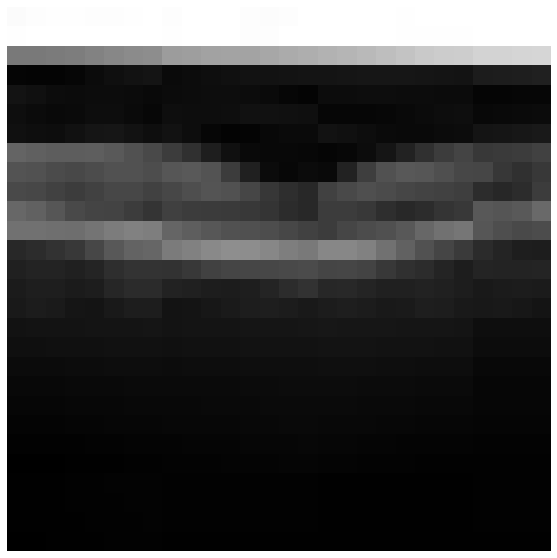

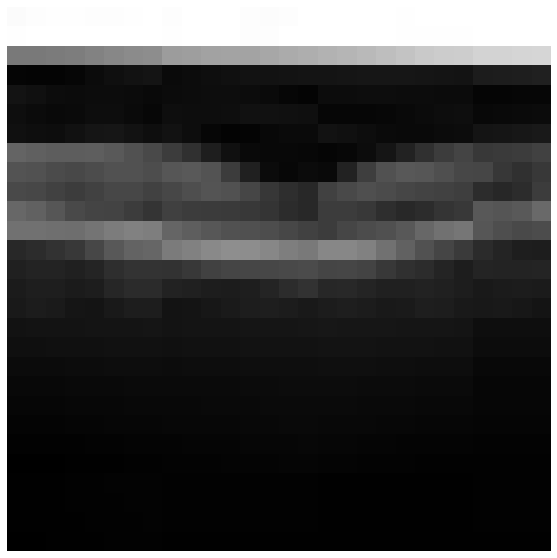

In [21]:
plt.figure(figsize=(10, 10));
plt.imshow(sample['image'][0][0].numpy(),cmap='gray');
plt.axis('off');
plt.show(0);

### Trainning

In [18]:
# Save model to directory
def save_model(model, best_model_wts, train_loss_return,train_acc_return,\
               val_loss_return, val_acc_return, save_name):
    
    state = {'best_model_wts':best_model_wts, 'model':model, \
             'train_loss':train_loss_return, 'train_acc':train_acc_return,\
             'val_loss':val_loss_return, 'val_acc':val_acc_return}
    
    torch.save(state, './octmnist/output/' + save_name +'.pt')
    return None

def train_model(model, dataloader, optimizer, loss_fn, num_epochs, verbose = False, save_name = 'model'):
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    y_pred = []
    y_true = []
    
    for i in tqdm(range(num_epochs)):
        print('Epoch: {}/{}'.format(i+1, num_epochs))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()

            for data in dataloader[p]:
                optimizer.zero_grad()
                image = data['image'].to(device)
                label = data['label'].to(device)
                #label = torch.squeeze(label, 1).long().to(device) try this if doesnt work
                output = model(image)
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
            
                if p== 'train':
                    loss.backward()
                    optimizer.step()
                
                if p== 'validate':
                    if i == num_epochs-1:
                        y_pred += preds.tolist()
                        y_true += label.tolist()
                       
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)

            
            if verbose or (i%10 == 0):
                time_elapsed = time.time() - since
                print('Phase:{}, Epoch Loss: {:.4f} | Epoch Acc: {:.4f} | {:.0f}m {:.0f}s'.format(p, np.average(loss_dict[p]),
                                                                                              epoch_acc, time_elapsed // 60, time_elapsed % 60))
                
            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            
            if p == 'validate':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    
            #scheduler.step()
             
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    save_model(model, best_model_wts, loss_dict['train'], acc_dict['train'],\
                       loss_dict['validate'], acc_dict['validate'], save_name=save_name)
    
    return model, acc_dict, loss_dict, y_pred, y_true

In [10]:
from torchvision import models as models
resnet18 = models.resnet18(pretrained = False)
resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride= (2,2) , padding=(3, 3), bias=False)  # change per task
resnet18.fc = nn.Linear(512,4, bias = False)  # change per task
#print(resnet18)

In [11]:
num_epochs = 5
lr = 0.0003
gamma=0.1
milestones = [0.5 * num_epochs, 0.75 * num_epochs]

In [21]:
model = resnet18
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
loss_fn = nn.CrossEntropyLoss()

model, acc_dict, loss_dict, y_pred, y_true = train_model(model.to(device), 
                                                                   dataloader, optimizer, loss_fn, 
                                                                   num_epochs = num_epochs , verbose = True, 
                                                                   save_name = 'Resnet18-OCT224-Run5')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5
----------
Phase:train, Epoch Loss: nan | Epoch Acc: 0.8074 | 1m 31s


 20%|██        | 1/5 [01:40<06:41, 100.30s/it]

Phase:validate, Epoch Loss: nan | Epoch Acc: 0.8336 | 1m 40s
Epoch: 2/5
----------
Phase:train, Epoch Loss: 0.5452 | Epoch Acc: 0.8591 | 3m 12s


 40%|████      | 2/5 [03:21<05:01, 100.63s/it]

Phase:validate, Epoch Loss: 0.4865 | Epoch Acc: 0.8650 | 3m 21s
Epoch: 3/5
----------
Phase:train, Epoch Loss: 0.4714 | Epoch Acc: 0.8768 | 4m 53s


 60%|██████    | 3/5 [05:02<03:22, 101.05s/it]

Phase:validate, Epoch Loss: 0.4403 | Epoch Acc: 0.8296 | 5m 3s
Epoch: 4/5
----------
Phase:train, Epoch Loss: 0.4304 | Epoch Acc: 0.8898 | 6m 34s


 80%|████████  | 4/5 [06:43<01:41, 101.12s/it]

Phase:validate, Epoch Loss: 0.4498 | Epoch Acc: 0.8781 | 6m 44s
Epoch: 5/5
----------
Phase:train, Epoch Loss: 0.4006 | Epoch Acc: 0.8989 | 8m 16s


100%|██████████| 5/5 [08:26<00:00, 101.35s/it]

Phase:validate, Epoch Loss: 0.4250 | Epoch Acc: 0.8889 | 8m 27s
Training complete in 8m 27s
Best val acc: 0.888940


<Figure size 640x480 with 0 Axes>

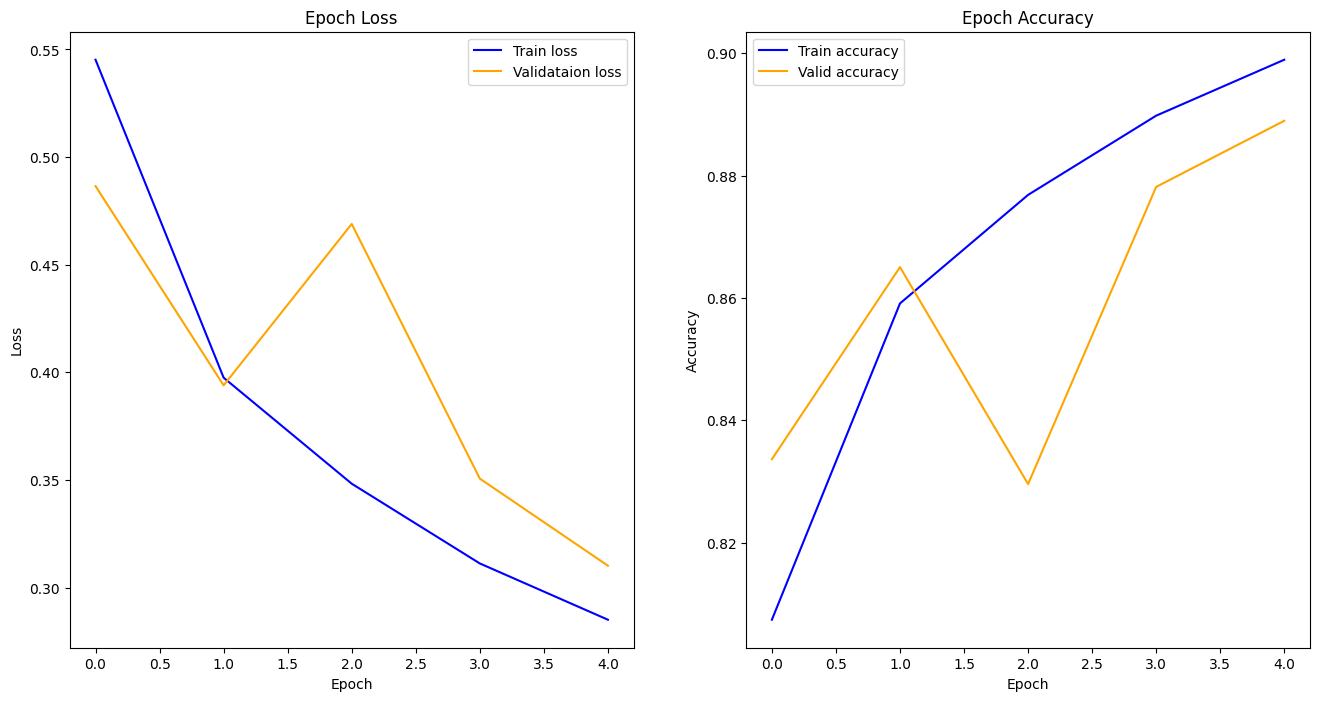

In [44]:
# Plotting loss and accuracy
plt.clf()
fig, axs = plt.subplots(1,2,figsize=(16,8))
axs[0].plot(loss_dict['train'], color='blue', label='Train loss')
axs[0].plot(loss_dict['validate'], color='orange', label='Validataion loss')
axs[1].plot(acc_dict['train'], color = 'blue', label='Train accuracy')
axs[1].plot(acc_dict['validate'], color = 'orange', label='Valid accuracy')
#axs[0].set(xticks = range(num_epochs))
#axs[1].set(xticks = range(num_epochs))
axs[0].set_title("Epoch Loss")
axs[1].set_title("Epoch Accuracy")
axs[0].set(xlabel="Epoch",ylabel="Loss")
axs[1].set(xlabel="Epoch",ylabel="Accuracy")
axs[0].legend(loc='best')
axs[1].legend(loc='best')
plt.show(0)

In [41]:
print('Predicted Class:\n', y_pred[:10])
print('True Class:\n', y_true[:10])

Predicted Class:
 [0, 1, 0, 0, 0, 3, 3, 3, 3, 0]
True Class:
 [0, 1, 0, 2, 0, 3, 3, 3, 3, 2]


In [24]:
print('Average Train Loss:', statistics.mean(loss_dict['train']))
print('Average Validation Loss:', statistics.mean(loss_dict['validate']))
print('Average Train Accuracy:', statistics.mean(acc_dict['train']))
print('Average Validation Accuracy:', statistics.mean(acc_dict['validate']))

Average Train Loss: 0.3774833885232457
Average Validation Loss: 0.40206258860437344
Average Train Accuracy: 0.8664074602213856
Average Validation Accuracy: 0.8590657311669129


### Testing

In [109]:
from torchvision import models as models
loss_fn = nn.CrossEntropyLoss()
# num_epochs = 30
lr = 0.0003
# gamma=0.1
# milestones = [0.5 * num_epochs, 0.75 * num_epochs]

resnet18 = models.resnet18(pretrained = False)
resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride= (2,2) , padding=(3, 3), bias=False)  # change per task
resnet18.fc = nn.Linear(512,4, bias = True)  # change per task
# #print(resnet18)

model = resnet18
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [110]:
path = './output/FL_global_model_run58.pt'  # change per task 
my_dict = torch.load(path)

In [111]:
dict1 = my_dict['model']

In [112]:
# load best weights
#path = './octmnist/output/local_model_site2_run58.pt'  # change per task 
#model.load_state_dict(my_dict)
model.load_state_dict(dict1)
#torch.load(path)

<All keys matched successfully>

In [113]:
def evaluate_model(model, dataloader, loss_fn, phase = 'test'):
    model.eval()
    running_correct = 0
    running_loss = 0
    running_total = 0
    y_pred = []
    y_true = []
    pred_score = []
    
    outputs = [] # testing 
    y_scores = torch.tensor([])
    y_targets = torch.tensor([])
    
    y_test = [] # binarized labedls
    
    for data in dataloader[phase]:
        image = data['image'].to(device)
        label = data['label'].to(device)
        target = data['label'].to(device) # tensor form of label
        
        
        label_binarized = label_binarize(label.cpu(), classes = [0,1,2,3]) # for ROC curve  # change per task
        if y_test ==[]:
            y_test = label_binarized
        else:
            y_test = np.concatenate((y_test, label_binarized), axis = 0)
        
        
        output = model(image)
        loss = loss_fn(output, label)
        _, preds = torch.max(output,dim = 1)
        y_true += label.cpu().numpy().tolist() # true label list
        y_pred += preds.cpu().tolist() # predicted label list
        
        #pred_scores = nn.Softmax(1)(output).cpu().detach().numpy()
        #pred_score += pred_scores.tolist() # predicted label probabilites list
        
        num_imgs = image.size()[0]
        running_correct += torch.sum(preds == label).item()
        running_loss += loss.item()*num_imgs
        running_total += num_imgs
        #output0 = np.array(output.detach().numpy())
        #outputs += output0.tolist() # outputs list to check what model is giving
        
        y_score = output.softmax(dim=-1).cpu()
        y_scores = torch.cat((y_scores, y_score), 0)
        
        targets = target.squeeze().long().cpu()
        targets = targets.float().resize_(len(targets), 1)
        y_targets = torch.cat((y_targets, targets), 0)
    
    y_targets = y_targets.detach().numpy()
    y_scores = y_scores.detach().numpy()
        
                
    accuracy = float(running_correct/running_total)
    loss = float(running_loss/running_total)
    
    
    return accuracy, loss, y_pred, y_true, pred_score, outputs, y_scores, y_targets, y_test

In [114]:
accuracy, loss, y_pred, y_true, pred_score, outputs, y_scores, y_targets, y_test = evaluate_model(model.to(device), 
                                                        dataloader, 
                                                        loss_fn, 
                                                        phase = 'test')

In [115]:
print('Eval Loss:', loss)
print('Eval Accuracy:', accuracy)
print('y_true',y_true[:10])
print('y_pred',y_pred[:10]) 


Eval Loss: 1.7513169746398927
Eval Accuracy: 0.71
y_true [2, 1, 3, 0, 1, 3, 0, 0, 3, 3]
y_pred [3, 1, 3, 0, 1, 3, 0, 0, 3, 3]


In [116]:
#print('pred_scores:\n',np.array(pred_score[:5])) # probability of each class
#print('model output:\n',np.array(outputs[:5])) # model output
print('y_scores:\n', y_scores[:5])
print('y_targets:\n', y_targets[:5])
print('y_test:\n', y_test[:5])

y_scores:
 [[4.24e-03 1.91e-03 2.12e-02 9.73e-01]
 [4.52e-03 9.95e-01 1.10e-07 1.76e-06]
 [1.13e-04 2.29e-06 1.26e-04 1.00e+00]
 [1.00e+00 1.51e-08 1.35e-05 3.21e-10]
 [5.68e-05 1.00e+00 3.85e-07 1.10e-05]]
y_targets:
 [[2.]
 [1.]
 [3.]
 [0.]
 [1.]]
y_test:
 [[0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]]


In [117]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def ROC_curve(y_test,y_score):
    y_test = y_test.squeeze()
    y_score = y_score.squeeze()

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 4     # change per task


    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'mediumorchid', 'lightcoral'])
    lw = 2
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
        print('AUC of Class',i, roc_auc[i])


    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('One-Vs-Rest Multi-Class ROC')
    plt.legend(loc="lower right")
    plt.show();
    return None



AUC of Class 0 0.9482933333333333
AUC of Class 1 0.9428426666666666
AUC of Class 2 0.8354133333333332
AUC of Class 3 0.9488719999999999


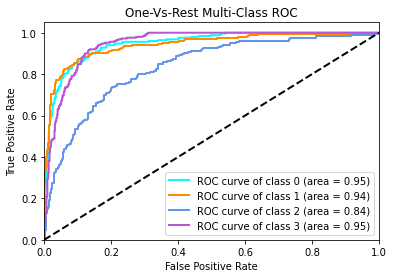

In [118]:
plt.clf()
ROC_curve(y_test,y_scores)

In [119]:
def getAUC(y_true, y_scores):
    '''AUC metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    '''
    y_true = y_true.squeeze()
    y_scores = y_scores.squeeze()

    auc = 0
    for i in range(y_scores.shape[1]):
        y_true_binary = (y_true == i).astype(float)
        y_score_binary = y_scores[:, i]
        auc += roc_auc_score(y_true_binary, y_score_binary)
    AUC = auc / y_scores.shape[1]

    return AUC

def getACC(y_true, y_scores):
    '''Accuracy metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    :param threshold: the threshold for multilabel and binary-class tasks
    '''
    y_true = y_true.squeeze()
    y_scores = y_scores.squeeze()

    ACC = accuracy_score(y_true, np.argmax(y_scores, axis=-1))

    return ACC


In [120]:
test_AUC = getAUC(y_targets, y_scores)
test_ACC = getACC(y_targets, y_scores)

In [121]:
print("Test AUC", test_AUC)
print("Test ACC", test_ACC)

Test AUC 0.9188553333333334
Test ACC 0.71


In [122]:
# Confusion Matrix
from sklearn.metrics import  confusion_matrix, roc_curve, auc
import itertools  

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
def cm(y_true_model_resnet_WA, y_pred_resnet_WA):
    cnf_matrix = confusion_matrix(y_true_model_resnet_WA, y_pred_resnet_WA)
    np.set_printoptions(precision=2)
    plt.figure()
    class_names = ['0:cnv','1 : dme','2 : drusen','3: healthy']  # change per task
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix')

Normalized confusion matrix
[[0.93 0.05 0.01 0.01]
 [0.17 0.76 0.02 0.06]
 [0.38 0.04 0.24 0.34]
 [0.02 0.02 0.04 0.92]]


<Figure size 432x288 with 0 Axes>

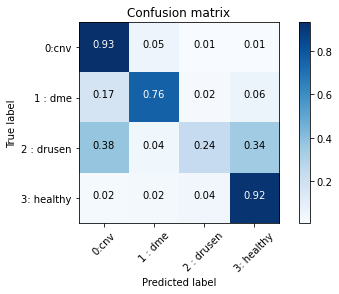

In [123]:
plt.clf()
cm(y_true,y_pred)
plt.show();

In [107]:
from sklearn.metrics import classification_report
class_names = ['0:cnv','1 : dme','2 : drusen','3: healthy']

ClassificationReport = classification_report(y_true, y_pred, target_names = class_names)
print(ClassificationReport)

              precision    recall  f1-score   support

       0:cnv       0.64      0.92      0.76       250
     1 : dme       0.85      0.71      0.77       250
  2 : drusen       0.72      0.15      0.25       250
  3: healthy       0.60      0.92      0.73       250

    accuracy                           0.68      1000
   macro avg       0.70      0.68      0.63      1000
weighted avg       0.70      0.68      0.63      1000

